In [1]:
import math, numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 

import sys
sys.path.insert(1, '_helperFuncs')
import fourier_funcs as ff
import animation_funcs as af
import drawing_funcs as df

import matplotlib.animation as animation   
Writer = animation.writers['ffmpeg']
writer = Writer(metadata=dict(artist='Aditya'), bitrate=1800)

import svgpathtools as spt
from svgpathtools import Path, Line, CubicBezier, svg2paths
import scipy.interpolate as interpolate

In [2]:
sample_percent = 1 
save_anim = 0 

In [3]:
from svgpathtools import svg2paths
import numpy as np

fname = "teddy_filtered.svg"
paths, attributes = svg2paths(fname)

print(len(paths))

6


In [8]:
NUM_SAMPLES = 500
DISTANCE_THRESHOLD = 100 

all_sampled_paths = []  

for path in paths:
    if len(path) == 0:
        continue

    subpath = []
    prev_point = None

    for i in range(NUM_SAMPLES):
        t = i / (NUM_SAMPLES)
        pt = path.point(t)
        complex_pt = pt.real + 1j * pt.imag

        if prev_point is not None:
            dist = abs(complex_pt - prev_point)
            if dist > DISTANCE_THRESHOLD and len(subpath) > 10:
                all_sampled_paths.append(np.array(subpath))
                subpath = []

        subpath.append(complex_pt)
        prev_point = complex_pt

    if len(subpath) > 10:
        all_sampled_paths.append(np.array(subpath))  

print("Total separate paths sampled:", len(all_sampled_paths))
for i, subpath in enumerate(all_sampled_paths):
    print(f"  Path {i} shape: {subpath.shape}")

Total separate paths sampled: 13
  Path 0 shape: (156,)
  Path 1 shape: (96,)
  Path 2 shape: (29,)
  Path 3 shape: (50,)
  Path 4 shape: (39,)
  Path 5 shape: (32,)
  Path 6 shape: (53,)
  Path 7 shape: (45,)
  Path 8 shape: (500,)
  Path 9 shape: (500,)
  Path 10 shape: (500,)
  Path 11 shape: (500,)
  Path 12 shape: (500,)


<IPython.core.display.Javascript object>


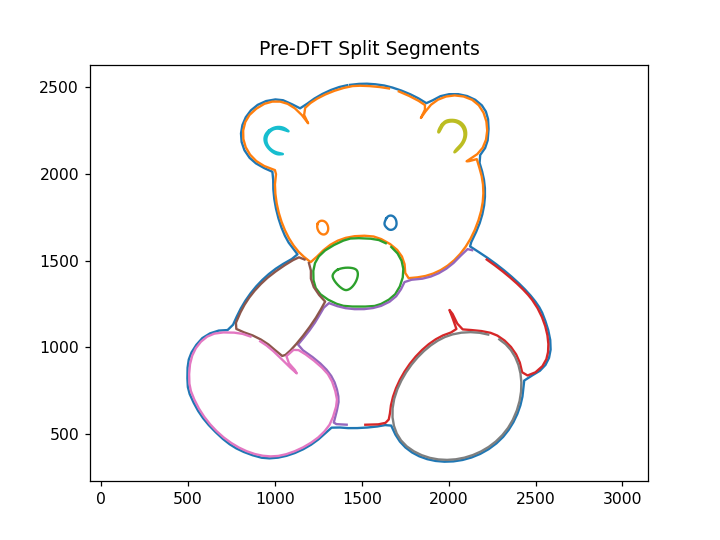

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for seg in all_sampled_paths:
    ax.plot(np.real(seg), np.imag(seg))
ax.set_title("Pre-DFT Split Segments")
ax.axis("equal")
plt.show()

In [10]:
def inv(points_fft, N):
    generated_function = np.zeros(N, dtype=np.complex128) \

    for tau in range(N):
        for k in range(len(points_fft)):
            generated_function[tau] += points_fft[k] * np.exp(1j * 2 * np.pi * k * tau / N)

In [11]:
for sampled_points in all_sampled_paths:
    N = len(sampled_points)
    points_fft = np.fft.fft(sampled_points, N)
    generated_function = ff.inv(points_fft, N)

    real_pts = np.real(generated_function)
    imag_pts = np.imag(generated_function)

<IPython.core.display.Javascript object>


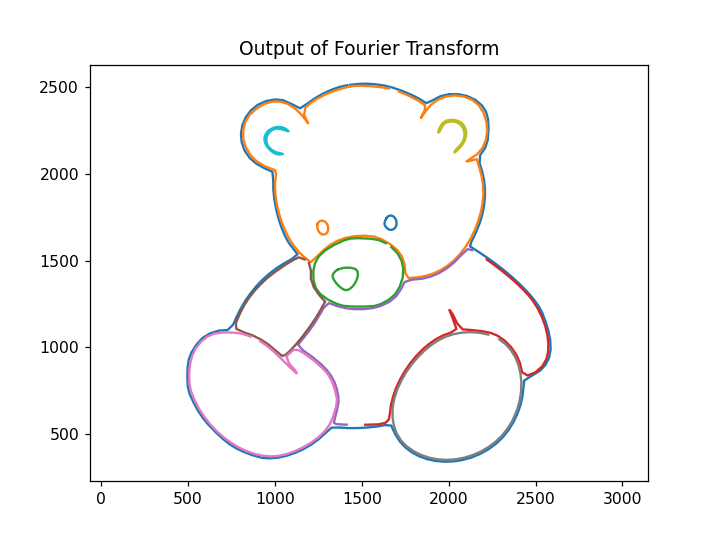

In [12]:
fig_dft_op = plt.figure("Output of 3D Sinusoidal Signal Generated")
plt.title("Output of Fourier Transform")

for sampled_points in all_sampled_paths:
    N = len(sampled_points)
    points_fft = np.fft.fft(sampled_points, N)
    generated_function = ff.inv(points_fft, N)

    real_pts = np.real(generated_function)
    imag_pts = np.imag(generated_function)

    plt.plot(real_pts, imag_pts)

plt.axis("equal") 
plt.show()

<IPython.core.display.Javascript object>


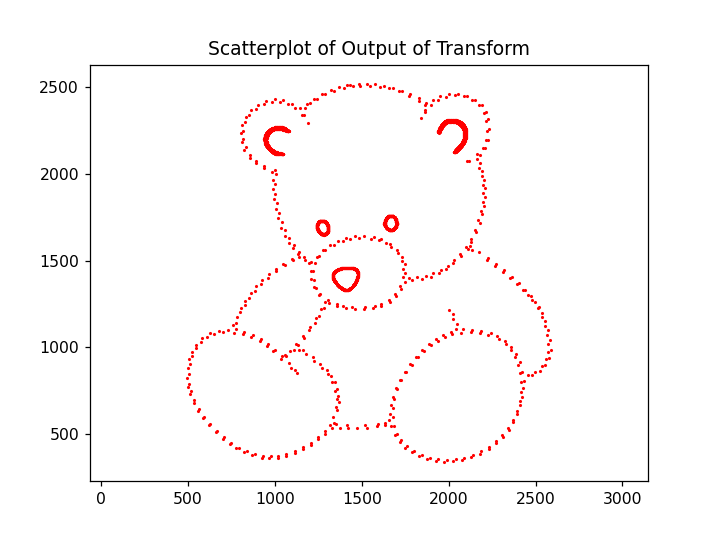

In [13]:
fig_gen_pts = plt.figure("Generated Points")
plt.title("Scatterplot of Output of Transform")

for sampled_points in all_sampled_paths:
    N = len(sampled_points)
    points_fft = np.fft.fft(sampled_points, N)
    generated_function = ff.inv(points_fft, N)

    real_pts = np.real(generated_function)
    imag_pts = np.imag(generated_function)

    plt.scatter(real_pts, imag_pts, color='red', s=1) 

plt.axis("equal")
plt.show()


<IPython.core.display.Javascript object>


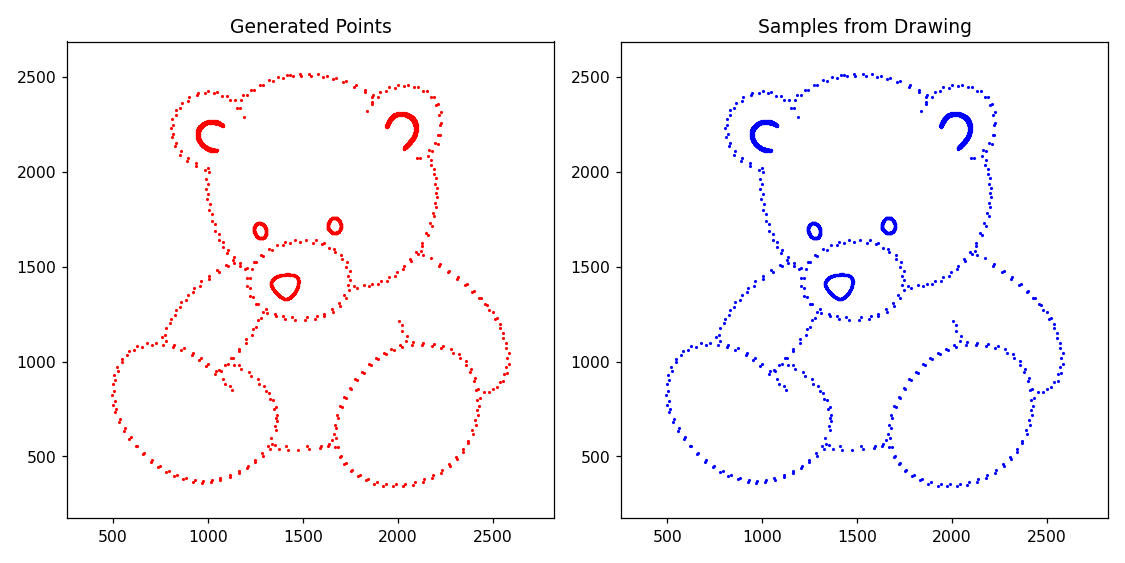

In [14]:
fig_cmp = plt.figure(
    "Comparison of Generated Signal vs Original Drawing", figsize=(10, 5)
)

plt.subplot(121)
for sampled_points in all_sampled_paths:
    N = len(sampled_points)
    points_fft = np.fft.fft(sampled_points, N)
    generated_function = ff.inv(points_fft, N)

    real_pts = np.real(generated_function)
    imag_pts = np.imag(generated_function)

    plt.scatter(real_pts, imag_pts, color='red', s=1)

plt.title("Generated Points")
plt.axis("equal")

plt.subplot(122)
for sampled_points in all_sampled_paths:
    plt.scatter(np.real(sampled_points), np.imag(sampled_points), color='blue', s=1)

plt.title("Samples from Drawing")
plt.axis("equal")

plt.tight_layout()
plt.show()


In [15]:
# Animation & Drawing Preparation for Multiple Paths
fft_data_per_path = []

for sampled_points in all_sampled_paths:
    N = len(sampled_points)
    points_fft = np.fft.fft(sampled_points, N)
    abs_fft = np.abs(points_fft) / N
    phase_fft = np.angle(points_fft)
    n_circles = len(points_fft)

    fft_data_per_path.append({
        "sampled_points": sampled_points,
        "points_fft": points_fft,     # This gives us the Fourier coefficients
        "abs_fft": abs_fft,          # we will later draw circles with radius = abs_fft[i]                   
        "phase_fft": phase_fft,     # gets the angle (phase offset) of each rotating circle.Tells us where the circle starts on the complex plane.
        "n_circles": n_circles,    # This is just the number of Fourier components. no of circles needed.
        "N": N
    })


<IPython.core.display.Javascript object>


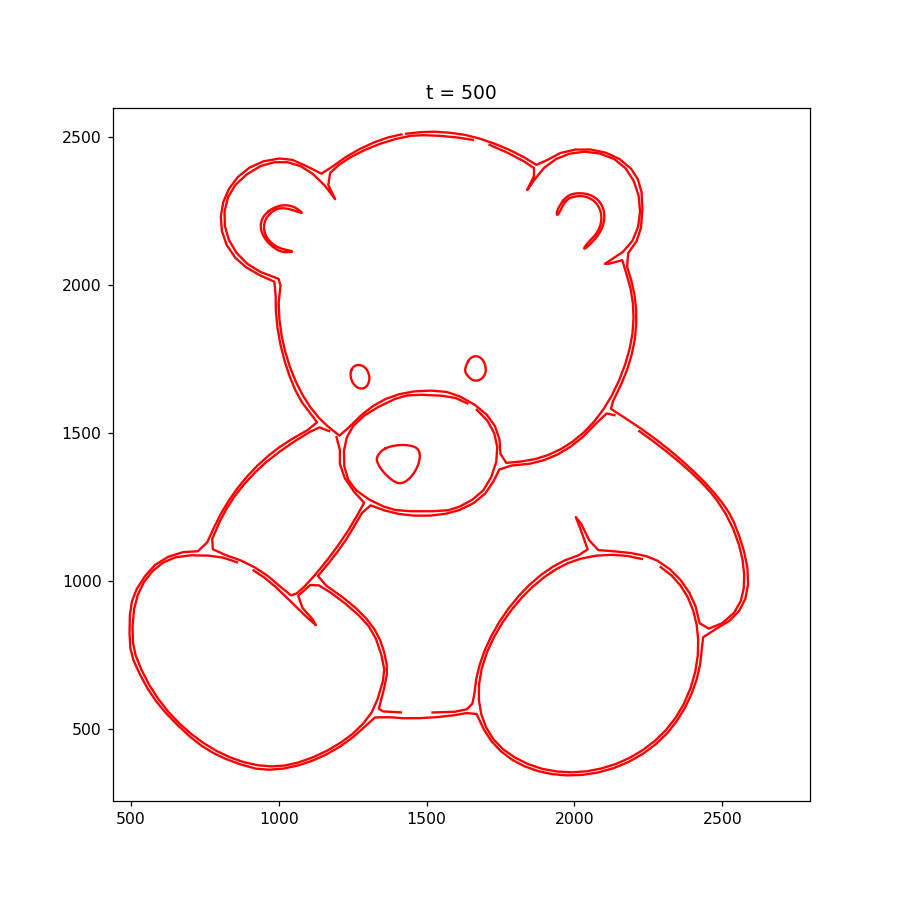

In [16]:
from matplotlib import pyplot as plt, animation
from matplotlib.animation import PillowWriter

fig_epic = plt.figure("Epicyclic Drawing of Multiple Paths", figsize=(8, 8))
ax = plt.axes()
ax.axis("equal")
ax.set_title("Epicyclic Drawing")

all_circles = []
all_real_pts = []
all_imag_pts = []
Ns = []

# Preprocessing: collect data for all paths
for data in fft_data_per_path:
    abs_fft = data["abs_fft"]
    phase_fft = data["phase_fft"]
    n_circles = data["n_circles"]
    N = data["N"]

    circles = af.get_init_vals(n_circles, abs_fft, phase_fft)
    all_circles.append(circles)

    real_pts = np.real(ff.inv(data["points_fft"], N))
    imag_pts = np.imag(ff.inv(data["points_fft"], N))
    all_real_pts.append(real_pts)
    all_imag_pts.append(imag_pts)
    Ns.append(N)

# Dynamic plot elements
dot_scs = []
scs = []
paths_drawn = []

def init_epic():
    elements = []
    for idx, data in enumerate(fft_data_per_path):
        abs_fft = data["abs_fft"]
        phase_fft = data["phase_fft"]
        circles = all_circles[idx]
        init_cs_pos = af.pos_at(0, abs_fft, phase_fft)

        for i in range(1, len(circles)):
            circles[i].center = init_cs_pos[i]
            ax.add_patch(circles[i])
            elements.append(circles[i])

        dot = ax.scatter([x[0] for x in init_cs_pos[1:]], 
                         [x[1] for x in init_cs_pos[1:]], color='black', alpha=0.75)
        sc = ax.scatter(all_real_pts[idx][0], all_imag_pts[idx][0], 
                        lw=5, color='g')
        path_line, = ax.plot([], [], color='r')

        dot_scs.append(dot)
        scs.append(sc)
        paths_drawn.append(path_line)

        elements.extend([dot, sc, path_line])
    return elements

def animate_epic(frame):
    elements = []
    for idx, data in enumerate(fft_data_per_path):
        abs_fft = data["abs_fft"]
        phase_fft = data["phase_fft"]
        circles = all_circles[idx]
        N = Ns[idx]

        if frame < N:
            new_cs_pos = af.pos_at(frame, abs_fft, phase_fft)

            for m in range(1, len(circles)):
                circles[m].center = new_cs_pos[m]
                circles[m].set_visible(True)
                elements.append(circles[m])

            paths_drawn[idx].set_data(all_real_pts[idx][:frame+1],
                                      all_imag_pts[idx][:frame+1])
            dot_scs[idx].set_offsets(new_cs_pos[1:])
            dot_scs[idx].set_alpha(0.75)
            scs[idx].set_offsets([[all_real_pts[idx][frame], 
                                   all_imag_pts[idx][frame]]])
            scs[idx].set_alpha(1)

            elements.extend([dot_scs[idx], scs[idx], paths_drawn[idx]])

        else:
            for m in range(1, len(circles)):
                circles[m].set_visible(False)
                elements.append(circles[m])

            # Hide both dot and green marker
            dot_scs[idx].set_alpha(0)
            scs[idx].set_alpha(0)

            # Just keep the path line
            paths_drawn[idx].set_data(all_real_pts[idx], all_imag_pts[idx])
            elements.append(paths_drawn[idx])

    ax.set_title(f"t = {frame}")
    return elements

max_frames = max(Ns)

anim_epic = animation.FuncAnimation(
    fig_epic, animate_epic, init_func=init_epic,
    frames=max_frames + 1, interval=20, blit=True, repeat=False
)

plt.show()


In [22]:
from matplotlib.animation import PillowWriter

writer = PillowWriter(fps=15)
frame_step = 2
frames_to_use = list(range(0, max_frames, frame_step))
pause_duration = 5  # in seconds
pause_frames = int(pause_duration * writer.fps)

with writer.saving(fig_epic, "epicyclic_drawing.gif", dpi=100):
    for i, frame in enumerate(frames_to_use):
        animate_epic(frame)
        writer.grab_frame()
        ax.set_title(f"t = {frame}")
        print(f"Saved frame {i+1}/{len(frames_to_use)} (t = {frame})", end="\r")

    # Explicitly call animate_epic on max_frames to hide everything properly
    print(f"\nRendering final frame at t = {max_frames} (epicycles hidden).")
    animate_epic(max_frames)
    writer.grab_frame()

    print(f"Adding pause of {pause_duration} seconds with {pause_frames} extra frames.")
    for j in range(pause_frames):
        writer.grab_frame()
        print(f"Saved pause frame {j+1}/{pause_frames}", end="\r")

print("\nGIF generation complete.")

Saved frame 150/150 (t = 298)
Rendering final frame at t = 300 (epicycles hidden).
Adding pause of 5 seconds with 75 extra frames.
Saved pause frame 75/75
GIF generation complete.
